# Dresden Summer School in Systems Biology (August 2019)
## Project 1: Stochastis simulation of gene expression
Project designed and tutored by [Christoph Zechner](https://scholar.google.com/citations?hl=en&user=Ah1KILgAAAAJ) and  [Stephan Baumgärtner](https://scholar.google.de/citations?hl=de&user=ve-32F4AAAAJ) 

[More info](https://www.csbdresden.de/join-us/summer-school/) 

In [1]:
import seaborn as sns
import numpy as np
from scipy.integrate import odeint
from scipy.stats import lognorm,norm
import pandas as pd

import matplotlib
import pylab as pl
from tqdm import tqdm

%matplotlib inline 
%qtconsole

# define some settings for plots
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.family'] = ['sans-serif']

# Creating an stochastic simulation with the Gillespie algorithm


## SSA or Gillespie algorithm

Simulates exact trajectories for a stochastic reaction system by sampling random numbers generating the time to the next reaction and which reaction given the current state of the system.

1. Initialise the system at t = 0: rate constants $c$ and initial molecule copy numbers
2. Calculate indiviual reaction propensities $a_{i}(x,c_{i})$ and $a_{0}(c,x) = \sum_{i}a_{i}(x,c_{i})$ based on current state
3. Generate two random numbers from the uniform distribution $r_{1},r_{2} \sim Unif(0,1)$
4. Update time: $t \longrightarrow t + \frac{1}{a_{0}(x)}\ln \frac{1}{r_{1}}$
5. Find reaction $j$ as the smallest integer satisfying $\sum_{j'=1}^{j}a_{j'}(x) > r_{2}a_{0}(x)$ and update state as $x \longrightarrow x + \nu_{j}$
6. `If` $t<t_{max}$ go to 2, `else` exit

**Some literature**

1. Gillespie, D. T. A rigorous derivation of the chemical master equation. Phys. A Stat. Mech. its Appl. 188, 404–425 (1992).

2. Gillespie, D. T. Exact stochastic simulation of coupled chemical reactions. J. Phys. Chem. 93555, 2340–2361 (1977).

3. Gillespie, D. T. Stochastic simulation of chemical kinetics. Annu. Rev. Phys. Chem. 58, 35–55 (2007).

In [2]:
def gillespie(state, c, smatrix, t_max):
    time = []
    time.append(0)
    t = 0
    waiting_times = []
    
    state_trace = []
    state_trace.append(state)
    
    while t < t_max: 
        r1, r2 = np.random.uniform(0,1,2)
        a = propensities(c, state)
        
        a_cum = np.cumsum(a)
        a_0 = a_cum[-1]
        
        t_old = t
        t = t + (1/a_0)*np.log(1/r1)
        time.append(t)
        waiting_times.append(t-t_old)
        
        condition = r2*a_0
        j = np.where(a_cum > condition)[0][0]
        state = state + smatrix[j]
        state_trace.append(state)
        
    return np.array(time), np.vstack(state_trace)


def propensities(c, state):
    return [c[0] * (1-state[0]), c[1] * state[0], c[2] * state[0], c[3] * state[1], c[4] * state[1], c[5] * state[2]]

In [3]:
#Parameters
state = [0,0,0]
c = np.array([
    0.03,  # gene activation rate
    0.003,   # gene inactivation rate
    0.5,   # transcription rate
    0.05, # RNA degradation rate
    0.1,   # RNA translation rate
    0.0005,  # protein degradation rate
])

smatrix = np.array([
    [1,0,0], #R1
    [-1,0,0], #R2
    [0,1,0], #R3
    [0,-1,0], #R4
    [0,0,1], #R5
    [0,0,-1], #R6
])

t_max = 300*60

In [4]:
time, states = gillespie(state, c, smatrix, t_max)

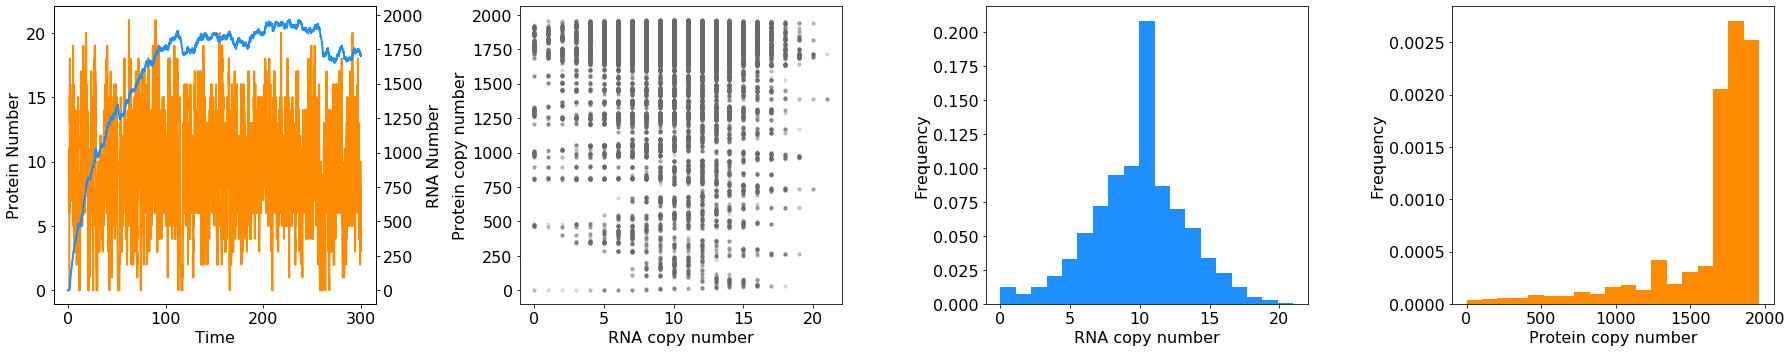

In [8]:
fig,ax = pl.subplots(1,4, figsize = (25,5))

#Protein and RNA number
ax[0].plot(time/60,states[:,1], lw = 2, color = 'darkorange')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Protein Number")

ax2 = ax[0].twinx()

ax2.plot(time/60,states[:,2], lw = 2, color = 'dodgerblue')
ax2.set_ylabel("RNA Number")

#RNA and portein number correlation
ax[1].scatter(states[:,1],states[:,2], c = 'dimgrey', s = 10, alpha = 0.2)
ax[1].set_xlabel('RNA copy number')
ax[1].set_ylabel('Protein copy number')

#RNA number state distribution accross the simulation 
bins = np.linspace(0,states[:,1].max(),20)
ax[2].hist(states[:,1],bins = bins, color = 'dodgerblue', density = True);
ax[2].set_xlabel('RNA copy number')
ax[2].set_ylabel('Frequency')

#Protein number state distribution accross the simulation
bins = np.linspace(0,states[:,2].max(),20)
ax[3].hist(states[:,2], bins = bins, color = 'darkorange', density = True);
ax[3].set_xlabel('Protein copy number')
ax[3].set_ylabel('Frequency')

pl.tight_layout()

# Calculating the gene ON and OFF distributions

In [13]:
on_events = list(data.query('Gene_diff == 1').index)
off_events = list(data.query('Gene_diff == -1').index)

In [14]:
on_times = []
off_times = []
if states[0,0] == 0: 
    for on , off in zip(on_events, off_events): 
        on_times.append(data.Time.iloc[off]-data.Time.iloc[on])
        try:
            off_times.append(data.Time.iloc[on_events[on_events.index(on)+1]]-data.Time.iloc[off])
        except:
            off_times.append(0)
else: 
    for on , off in zip(on_events, off_events): 
        off_times.append(data.Time.iloc[on]-data.Time.iloc[off])
        try:
            on_times.append(data.Time.iloc[off_events[off_events.index(off)+1]]-data.Time.iloc[on])
        except:
            on_times.append(0)
on_times = np.vstack(on_times)
off_times = np.vstack(off_times)

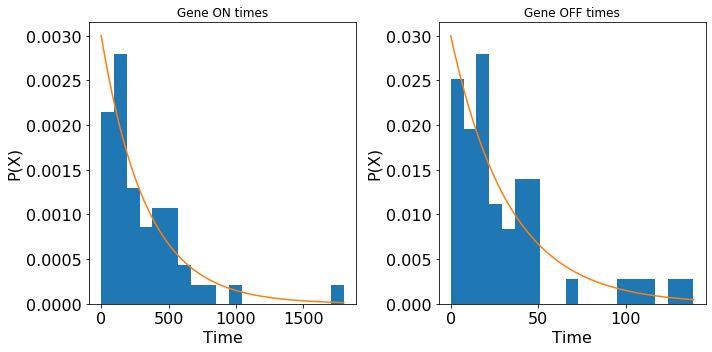

In [18]:
fig, ax = pl.subplots(1,2,figsize=(10,5))

#Gene ON times distribution
bins = np.linspace(0,on_times.max(),20)
ax[0].hist(on_times, bins = bins, density=True)
x = np.linspace(0,on_times.max(),200)
y = c[1]*np.exp(-c[1]*x)
ax[0].plot(x,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('P(X)')
ax[0].set_title('Gene ON times')

#Gene OFF time distribution
bins = np.linspace(0,off_times.max(),20)
ax[1].hist(off_times, bins = bins, density = True)
x = np.linspace(0,off_times.max(),200)
y = c[0]*np.exp(-c[0]*x)
ax[1].plot(x,y)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('P(X)')
ax[1].set_title('Gene OFF times')
pl.tight_layout()

Both the times the gene is ON an the times the gene is OFF correspond to exponential distributions. This is due to the fact that we consider the activation and deactivation of the gene to follow linear propensities. Therefore, their distributions are exponential. 

# Calculating the distribution of the ON-OFF cycle time. 

In [9]:
data = pd.DataFrame([time, states[:,0],states[:,1],states[:,2]], index = ['Time','Gene_state','RNA','Protein']).T

In [10]:
data['Gene_diff'] = data.Gene_state.diff()

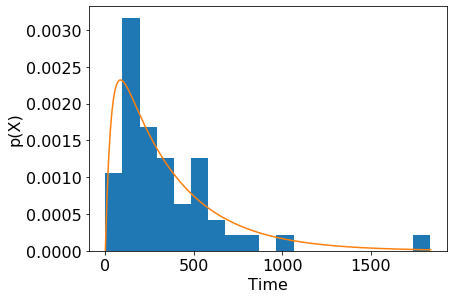

In [11]:
query = data.query('Gene_diff == 1')
delta_t = []
for i in range(len(query)-1): 
    t1 = query.Time.iloc[i]
    t2 = query.Time.iloc[i+1]
    delta_t.append(t2 - t1)
delta_t = np.vstack(delta_t)

fig, ax = pl.subplots(1,1)
bins = np.linspace(0,delta_t.max(),20)
ax.hist(delta_t, bins = bins, density = True)
x = np.linspace(0,delta_t.max(),200)
y = ((c[0]*c[1])/(c[1]-c[0]))*(np.exp(-c[0]*x)-np.exp(-c[1]*x))
ax.plot(x,y)
pl.tight_layout()
ax.set_xlabel('Time')
ax.set_ylabel('p(X)')

The distribution of ON-OFF cycle times corresponds to a convoluted distribution of two exponential distributions. This is reasonable because the cycle time is dependent on two variables c1 (Gene ON propensity) and c2 (Gene OFF propensity) that both correspond to exponential distributions.

# Generating different stochastic simulations

In [19]:
def lots_gillespies(state, c, smatrix, t_max, timy, it_number):
    simulations = []
    for i in tqdm(range(it_number)):
        time, states = gillespie(state,c,smatrix,t_max)
        simulation = sample_times(timy,time,states)
        simulations.append(simulation)
    return simulations
        

In [20]:
def sample_times(timy, time, states):
    data = pd.DataFrame([time, states[:,0],states[:,1],states[:,2]], index = ['Time','Gene_state','RNA','Protein']).T
    sampled_data = pd.DataFrame(timy,columns=['Time'])
    sampled_data['Gene'], sampled_data['RNA'], sampled_data['Protein']= [pd.Series()]*3
    sampled_data = sampled_data.fillna(0)
    for time in timy:    
        condition1 = data.Time-time <= 0 
        data_condition1 = data[condition1]
        condition2 = abs(data_condition1.Time-time)==min(abs(data_condition1.Time-time))
        data_condition2 = data_condition1[condition2]
        sampled_data.iloc[sampled_data[sampled_data['Time']==time].index[0],1] = float(data_condition2['Gene_state'])
        sampled_data.iloc[sampled_data[sampled_data['Time']==time].index[0],2]= float(data_condition2['RNA'])
        sampled_data.iloc[sampled_data[sampled_data['Time']==time].index[0],3]= float(data_condition2['Protein'])
    return sampled_data

In [23]:
#parameters
t_max = 150*60
it_number = 100
timy = np.linspace(0.1 ,t_max, 150)
c = np.array([
    0.03,  # gene activation rate
    0.003,   # gene inactivation rate
    0.5,   # transcription rate
    0.05, # RNA degradation rate
    0.1,   # RNA translation rate
    0.0005,  # protein degradation rate
])


smatrix = np.array([
    [1,0,0], #R1
    [-1,0,0], #R2
    [0,1,0], #R3
    [0,-1,0], #R4
    [0,0,1], #R5
    [0,0,-1], #R6
])

In [24]:
#simulation
my_simulations = lots_gillespies(state, c, smatrix, t_max, timy, it_number)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:27<00:00,  5.07s/it]


Text(0, 0.5, 'Protein number')

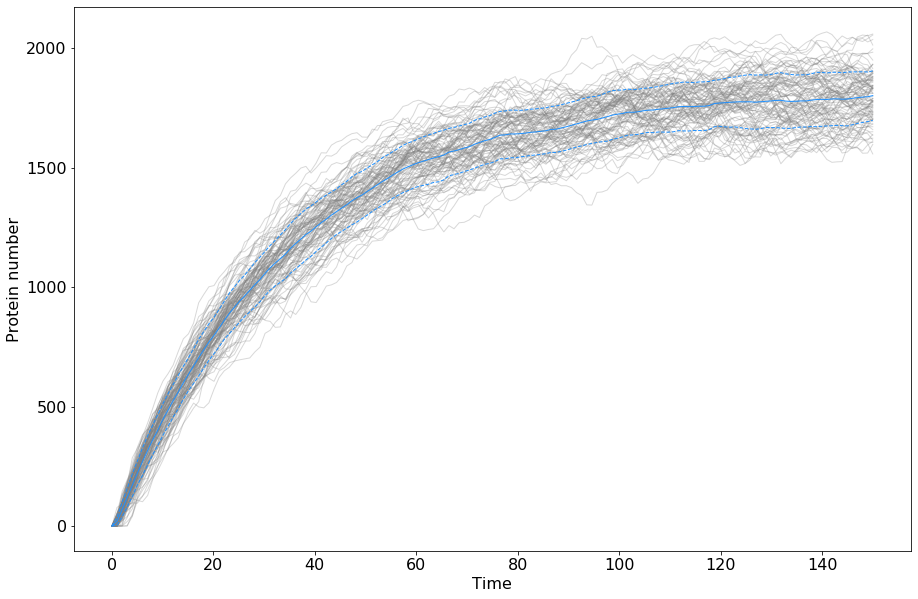

In [25]:
#Plotgting protein values from different simulations
prot_values = np.vstack([np.array(i.Protein) for i in my_simulations]).T
RNA_values = np.vstack([np.array(i.RNA) for i in my_simulations]).T
timy = np.array(timy)

fig, ax = pl.subplots(1,1, figsize=(15,10))
ax.plot(timy/60,prot_values, color = 'grey',alpha = 0.3, lw = 1)
ax.plot(timy/60,prot_values.mean(1), color = 'dodgerblue', lw = 1)
ax.plot(timy/60,prot_values.mean(1)+prot_values.std(1),'--', color = 'dodgerblue', lw = 1)
ax.plot(timy/60,prot_values.mean(1)-prot_values.std(1),'--', color = 'dodgerblue', lw = 1)
ax.set_xlabel('Time')
ax.set_ylabel('Protein number')

# Establishing the differential equations derived from the Chemical Master Equation (CME) moments

In [26]:
def model(m, t, c):
    dm = np.zeros(14)
    
    c1 = c[0]
    c2 = c[1]
    c3 = c[2]
    c4 = c[3]
    c5 = c[4]
    c6 = c[5]
    
    x_1 = m[0]
    x_2 = m[1]
    x_3 = m[2]
    x_4 = m[3]
    x_11 = m[4]
    x_12 = m[5]
    x_13 = m[6]
    x_14 = m[7]
    x_22 = m[8]
    x_23 = m[9]
    x_24 = m[10]
    x_33 = m[11]
    x_34 = m[12]
    x_44 = m[13]

    dm[0] = x_2*c2 - x_1*c1
    dm[1] = x_1*c1 - x_2*c2
    dm[2] = x_2*c3 - x_3*c4
    dm[3] = x_3*c5 - x_4*c6
    dm[4] = x_1*c1 + x_2*c2 - 2*x_11*c1 + 2*x_12*c2
    dm[5] = x_11*c1 - x_2*c2 - x_1*c1 - x_12*c1 - x_12*c2 + x_22*c2
    dm[6] = x_12*c3 - x_13*c1 - x_13*c4 + x_23*c2
    dm[7] = x_13*c5 - x_14*c1 - x_14*c6 + x_24*c2
    dm[8] = x_1*c1 + x_2*c2 + 2*x_12*c1 - 2*x_22*c2
    dm[9] = x_13*c1 + x_22*c3 - x_23*c2 - x_23*c4
    dm[10] = x_14*c1 - x_24*c2 + x_23*c5 - x_24*c6
    dm[11] = x_2*c3 + x_3*c4 + 2*x_23*c3 - 2*x_33*c4
    dm[12] = x_24*c3 + x_33*c5 - x_34*c4 - x_34*c6
    dm[13] = x_3*c5 + x_4*c6 + 2*x_34*c5 - 2*x_44*c6
    
    return dm

In [27]:
x_moments = np.zeros(14)
x_moments[0], x_moments[4] = 1, 1

In [28]:
moments = odeint(model, x_moments, timy, args=(c,))

In [29]:
RNA_mean = moments[:,2]
RNA_std = np.sqrt(moments[:,11]-RNA_mean**2)
prot_mean = moments[:,3]
prot_std = np.sqrt(moments[:,13]-prot_mean**2)

Text(0, 0.5, 'Protein copy number')

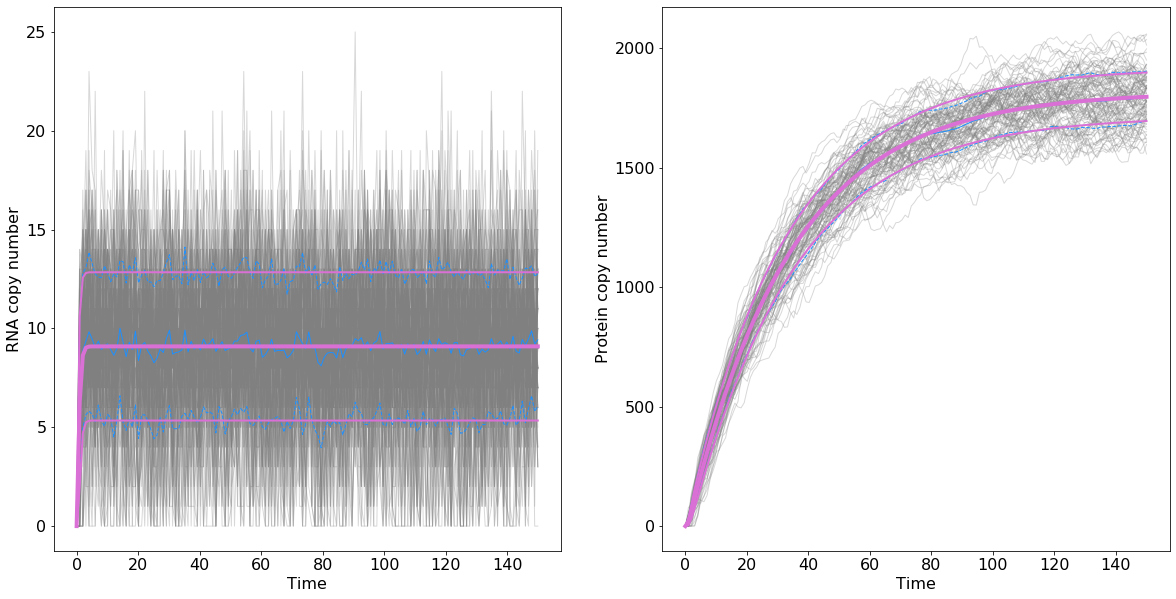

In [30]:
fig, ax = pl.subplots(1,2, figsize=(20,10))

#RNA Comparison simulations and moments 
#simulation
ax[0].plot(timy/60,RNA_values, color = 'grey',alpha = 0.3, lw = 1)
ax[0].plot(timy/60,RNA_values.mean(1), color = 'dodgerblue', lw = 1)
ax[0].plot(timy/60,RNA_values.mean(1)+RNA_values.std(1),'--', color = 'dodgerblue', lw = 1)
ax[0].plot(timy/60,RNA_values.mean(1)-RNA_values.std(1),'--', color = 'dodgerblue', lw = 1)

#ODE moments
ax[0].plot(timy/60,RNA_mean, color = 'orchid', lw = 4)
ax[0].plot(timy/60,RNA_mean+RNA_std, color = 'orchid', lw = 2)
ax[0].plot(timy/60,RNA_mean-RNA_std, color = 'orchid', lw = 2)


#plot labels
ax[0].set_xlabel('Time')
ax[0].set_ylabel('RNA copy number')

#---------------------------------------------------------------------------------------------------#
#RNA Comparison simulations and moments 
#RNA Comparison simulations and moments 
#simulation
ax[1].plot(timy/60,prot_values, color = 'grey',alpha = 0.3, lw = 1)
ax[1].plot(timy/60,prot_values.mean(1), color = 'dodgerblue', lw = 1)
ax[1].plot(timy/60,prot_values.mean(1)+prot_values.std(1),'--', color = 'dodgerblue', lw = 1)
ax[1].plot(timy/60,prot_values.mean(1)-prot_values.std(1),'--', color = 'dodgerblue', lw = 1)

#ODE moments
ax[1].plot(timy/60,prot_mean, color = 'orchid', lw = 4)
ax[1].plot(timy/60,prot_mean+prot_std, color = 'orchid', lw = 2)
ax[1].plot(timy/60,prot_mean-prot_std, color = 'orchid', lw = 2)


#plot labels
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Protein copy number')


# Bayesian inference of simulated parameters using a MCMC approach

# Metropolis-Hastings algorithm

The MH algorithm for sampling from a target distribution $π$, using transition kernel $Q$, consists of the following steps:

* Initialize, $X1=x1$ say.  

For $t=1,2,…$

* Sample y from $Q(y|xt)$. Think of y as a “proposed” value for $x_t+1$.

* Compute  
$A= \min \left( 1, \frac{\pi(y)Q(x_t | y)}{\pi(x_t)Q(y | x_t)} \right).$ $A$ is often called the “acceptance probabilty”.

* With probability $A$ “accept” the proposed value, and set $x_t+1=y$. Otherwise set $xt+1=xt$

In [31]:
def bootstraping(prot_valus, N):
    boot_mean = []
    boot_sec = []
    simulations = prot_values.shape[1]
    for j in range(N):
        random = prot_values[:,np.random.randint(0,simulations, simulations)]
        boot_mean.append(random.mean(1))
        boot_sec.append(np.mean(random**2, axis=1))

    means = np.vstack(boot_mean).T
    sec_order = np.vstack(boot_sec).T

    data = np.array([
        means.mean(1),
        sec_order.mean(1),
        means.std(1)**2,
        sec_order.std(1)**2
    ]).T
    return data

In [32]:
def log_likelihood(data, moments):
    l_log = 0
    for tp, mp in zip(data,moments):
        if np.sum(np.array([tp[2],tp[3]]) > 0) > 1:
            l_log += ((tp[0]-mp[3])**2/(tp[2]))+((tp[1]-mp[13])**2/(tp[3]))
    return -l_log

In [33]:
N=1000
data = bootstraping(prot_values,N)

In [34]:
parameters_to_be_guessed = np.array([0,1,2,4], dtype = int)
hast_it = 20000
proposed_sigma = 0.02
def mh(hast_it, proposed_sigma, parameters_to_be_guessed):
    global model
    global data
    global x_moments
    global timy
    
    acceptance_counter = 0
    l_record = np.zeros(hast_it)

    chain = np.zeros((hast_it, len(parameters_to_be_guessed)))
    chain[0] = 0.01

    c_temp = np.copy(c)
    c_temp[parameters_to_be_guessed] = chain[0]

    moments = odeint(model, x_moments, timy, args=(c_temp,))
    l_old = log_likelihood(data, moments)
    l_record[0] = l_old
    
    for i in tqdm(range(1,hast_it)):
        current_parameters = chain[i-1]
        proposed_parameters = np.random.lognormal(np.log(current_parameters), proposed_sigma)

        plog_back = np.sum(lognorm.pdf(np.exp(current_parameters), proposed_sigma, 0, np.exp(proposed_parameters)))
        plog_for = np.sum(lognorm.pdf(np.exp(proposed_parameters), proposed_sigma, 0, np.exp(current_parameters)))

        c_temp[parameters_to_be_guessed] = proposed_parameters
        moments = odeint(model, x_moments, timy, args=(c_temp,))
        l_new = log_likelihood(data, moments)

        alpha = np.min(
            [1, np.exp(l_new + plog_back - l_old - plog_for)]
        )

        if alpha >= np.random.uniform(0,1,1):
            chain[i] = proposed_parameters
            l_old = l_new
            acceptance_counter += 1
        else: 
            chain[i] = chain[i-1]

        l_record[i] = l_old
        
    return chain, l_record

In [35]:
chain, l_record = mh(hast_it,proposed_sigma,parameters_to_be_guessed)

100%|████████████████████████████████████████████████████████████████████████████| 19999/19999 [12:09<00:00, 27.40it/s]


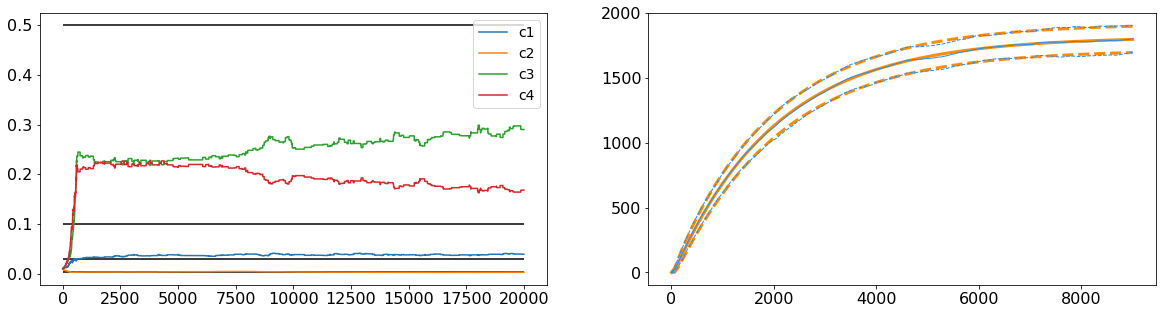

In [36]:
fig, ax = pl.subplots(1,2,figsize=(20,5))

for i in range(0,4):
    ax[0].plot(range(hast_it), chain[:,i])
ax[0].legend(['c1','c2','c3','c4','c5','c6'])
ax[0].hlines(c[parameters_to_be_guessed], 0, hast_it)

sd = np.sqrt(moments[:,13]-moments[:,3]**2)
ax[1].plot(timy, moments[:, 3], lw=3, color="darkorange")
ax[1].plot(timy, moments[:, 3]+sd,'--', lw=3, color="darkorange")
ax[1].plot(timy, moments[:, 3]-sd,'--', lw=3, color="darkorange")


ax[1].plot(timy,prot_values.mean(1), color = 'dodgerblue', lw = 1)
ax[1].plot(timy,prot_values.mean(1)+prot_values.std(1),'--', color = 'dodgerblue', lw = 1)
ax[1].plot(timy,prot_values.mean(1)-prot_values.std(1),'--', color = 'dodgerblue', lw = 1)

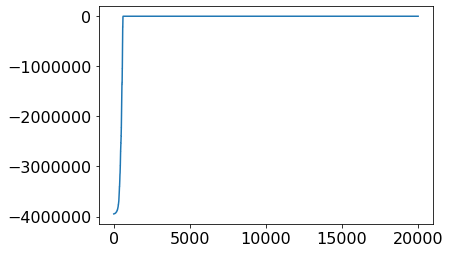

In [37]:
fig, ax = pl.subplots(1,1)
ax.plot(l_record)

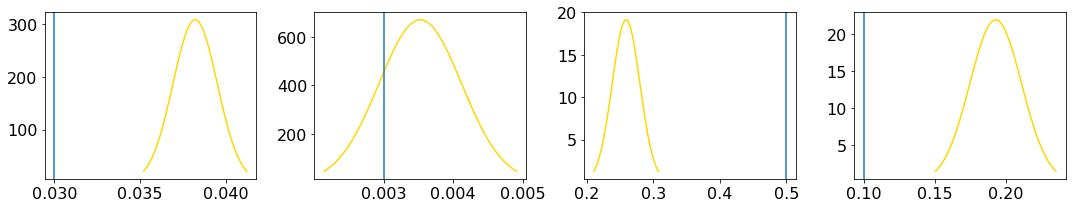

In [39]:
burn_in = 3000
fig, ax = pl.subplots(1,4,figsize=(15,3))
for i , j in zip(parameters_to_be_guessed,range(0,len(parameters_to_be_guessed))): 
    mu1 = chain[burn_in:,j].mean()
    sigma1 = chain[burn_in:,j].std()
    x = np.linspace(norm.ppf(0.01,mu1,sigma1),norm.ppf(0.99, mu1,sigma1),100)
    ax[j].plot(x, norm.pdf(x, mu1,sigma1),color='gold')
    ax[j].axvline(c[i])
pl.tight_layout()
                 